In [9]:
import himalaya.scoring
import matplotlib.pyplot as plt
import simplstyles
import numpy as np
import pandas as pd
import seaborn as sns
from himalaya.backend import set_backend, get_backend
from himalaya.ridge import RidgeCV, GroupRidgeCV

from simulation import generate_dataset

In [10]:
set_backend('cupy', on_error='warn')
backend = get_backend()
plt.style.use('nord-light-talk')
sns.set_theme(style='whitegrid')

In [11]:
d_list = [100, 100, 100]
scalars = [1 / 5, 3 / 5, 1 / 5]
n_targets = 10000
n_samples_train = 10000
n_samples_test = 100
n_samples = n_samples_train + n_samples_test
noise_scalar = 0.1

In [12]:
alphas = np.logspace(-5, 5, 10)
cv = 50
score_func = himalaya.scoring.r2_score

In [13]:
Xs, Y = generate_dataset(d_list, scalars, n_targets, n_samples, noise_scalar)

train joint model

In [14]:
banded_solver_params = dict(n_iter=10, alphas=alphas, warn=False, score_func=score_func, n_targets_batch=1000)
joint_model = GroupRidgeCV(groups="input", solver_params=banded_solver_params)

In [15]:
joint_model.fit([x[:n_samples_train] for x in Xs], Y[:n_samples_train])
joint_score = joint_model.score([x[n_samples_train:] for x in Xs], Y[n_samples_train:])
joint_score = backend.to_numpy(joint_score)

[........................................] 100% | 131.35 sec | 10 random sampling with cv | 


Text(0.8910345435142517, 0, '0.89')

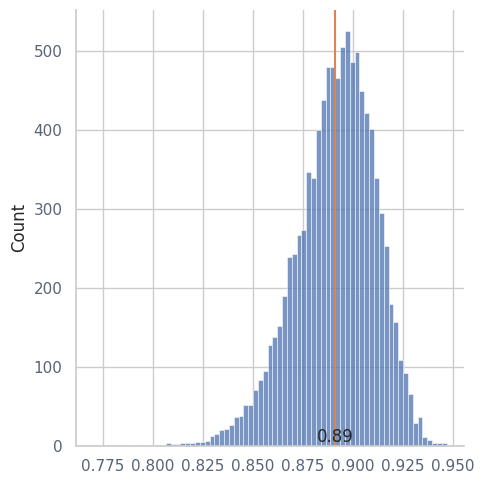

In [19]:
sns.displot(joint_score)
plt.axvline(joint_score.mean(), label="mean", color="C1")
plt.text(joint_score.mean(), 0, f"{joint_score.mean():.2f}", ha='center', va='bottom')

train single models

In [17]:
solver_params = dict(warn=False, score_func=score_func, n_targets_batch=1000)
single_model = RidgeCV(alphas=alphas, cv=cv, solver_params=solver_params)
single_model.fit(Xs[0][:n_samples_train], Y[:n_samples_train])
score_0 = single_model.score(Xs[0][n_samples_train:], Y[n_samples_train:])
score_0 = backend.to_numpy(score_0)

KeyboardInterrupt: 

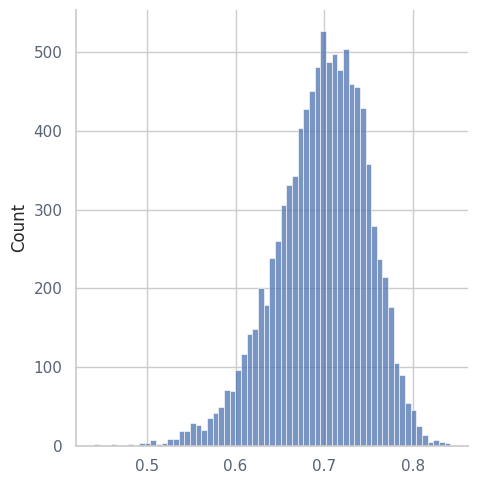

In [40]:
sns.displot(score_0)

In [41]:
solver_params = dict(warn=False, score_func=score_func, n_targets_batch=1000)
single_model = RidgeCV(alphas=alphas, cv=cv, solver_params=solver_params)
single_model.fit(Xs[1][:n_samples_train], Y[:n_samples_train])
score_1 = single_model.score(Xs[1][n_samples_train:], Y[n_samples_train:])
score_1 = backend.to_numpy(score_1)

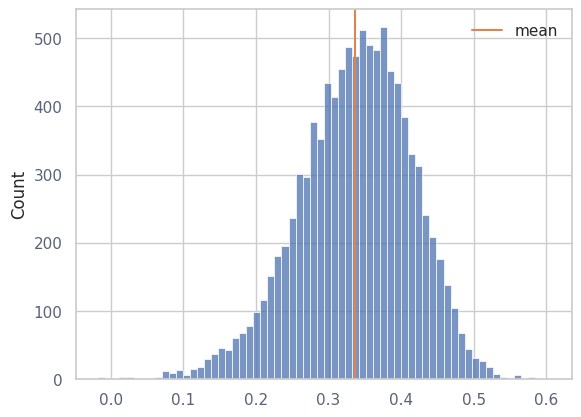

In [42]:
sns.histplot(score_1)
plt.axvline(score_1.mean(), label="mean", color="C1")
plt.legend()

Calculate unique and shared variance

In [43]:
shared = (score_0 + score_1) - joint_score
x0_unique = score_0 - shared
x1_unique = score_1 - shared

In [44]:
shared = backend.to_numpy(shared)
x0_unique = backend.to_numpy(x0_unique)
x1_unique = backend.to_numpy(x1_unique)

create pandas dataset of all scores for analysis

In [48]:
scores = pd.DataFrame()
scores[r"$(X_1\cup X_2)\beta \approx Y$"] = joint_score
scores[r"$X_1\beta \approx Y$"] = score_0
scores[r"$X_2\beta \approx Y$"] = score_1
scores[r"$R^2(X_1\beta \approx Y)\cap R^2(X_2\beta \approx Y)$"] = shared
scores[r"$R^2(X_1\beta \approx Y) \setminus R^2(X_2\beta \approx Y)$"] = x0_unique
scores[r"$R^2(X_2\beta \approx Y) \setminus R^2(X_1\beta \approx Y)$"] = x1_unique
scores.head()

,$(X_1\cup X_2)\beta \approx Y$,$X_1\beta \approx Y$,$X_2\beta \approx Y$,$R^2(X_1\beta \approx Y)\cap R^2(X_2\beta \approx Y)$,$R^2(X_1\beta \approx Y) \setminus R^2(X_2\beta \approx Y)$,$R^2(X_2\beta \approx Y) \setminus R^2(X_1\beta \approx Y)$
0,0.869759,0.653476,0.213901,-0.002382,0.655858,0.216283
1,0.881629,0.749666,0.412018,0.280055,0.469611,0.131963
2,0.908677,0.678622,0.390670,0.160615,0.518007,0.230055
3,0.930530,0.785314,0.364940,0.219725,0.565590,0.145216
4,0.886323,0.693651,0.277439,0.084767,0.608884,0.192672


Text(0.0, 1.0, 'Variance Partitioning')

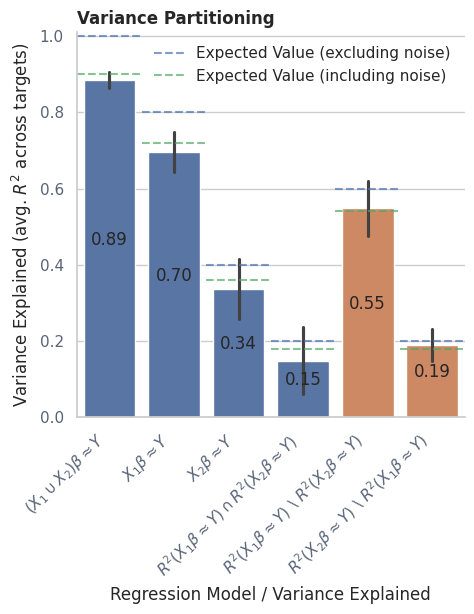

In [51]:
fig, ax = plt.subplots(figsize=(5, 5))

sns.barplot(
    data=scores,
    palette=["C0", "C0", "C0", "C0", "C1", "C1"],  # Define colors: one for joint/X₁/X₂, one for unique/shared
    ax=ax,
    errorbar='sd',
)
sns.despine(fig)
theoretical_scores = [
    sum(scalars),
    scalars[0] + scalars[1],
    scalars[0] + scalars[2],
    scalars[0], scalars[1],
    scalars[2]
]
theoretical_scores_nosise = [score * (1 - noise_scalar) for score in theoretical_scores]

# Add lines indicating the maximum possible height for each bar
for idx, column in enumerate(scores.columns):  # iterate over rows in the DataFrame
    xmin = idx / len(scores.columns)  # Calculate xmin for each bar
    xmax = (idx + 1) / len(scores.columns)  # Calculate xmax for each bar
    plt.axhline(theoretical_scores[idx], linestyle='--', alpha=0.7, color='C0',
                xmin=xmin, xmax=xmax, label=fr'Expected Value (excluding noise)' if idx == 0 else "")
    plt.axhline(theoretical_scores_nosise[idx], linestyle='--', alpha=0.7, color='C2',
                xmin=xmin, xmax=xmax, label=fr'Expected Value (including noise)' if idx == 0 else "")

    plt.text(idx, scores[column].mean() / 2, f"{scores[column].mean():.2f}", ha='center', va='bottom')

plt.xticks(range(len(scores.columns)), scores.columns, rotation=45, ha='right')

plt.ylim(0, 1.01)

# Ensure the legend is displayed properly
plt.legend()
plt.ylabel(r"Variance Explained (avg. $R^2$ across targets)")
plt.xlabel(r"Regression Model / Variance Explained")
plt.title("Variance Partitioning")